# Adaptive Conformal Prediction for Uncertainty Estimation in Classification

In this section, we introduce a procedure for obtaining uncertainty estimates for classification predictions using Conformal Prediction. We start with an initial heuristic notion of uncertainty based on the softmax outputs of the model's predictions. The goal is to refine this heuristic using the rigorous framework of conformal prediction.

1. **Initial Heuristic Uncertainty**:
   We begin with a pre-trained model that generates predictions for a given input $x$. The model provides a set of softmax probabilities $\pi_1(x), \ldots, \pi_K(x)$, where $K$ is the number of classes. We greedily include classes in the set until we reach the true label $y$, stopping at that point. This procedure, while not perfect, gives us an initial heuristic notion of uncertainty. However, we aim to transform this into a more rigorous notion.

2. **Defining the Score Function**:
   We define a score function $s(x, y)$ that reflects the uncertainty. The score function aggregates the softmax outputs of all classes and stops at the true label $y$:
   

   $$s(x, y) = \sum_{j=1}^k \pi_j(x) \quad \text{where } y = \pi_k(x)$$
   
   Unlike the score used earlier, this function considers all class probabilities, not just the true class.

3. **Quantile Computation**:
   The next step is to compute the quantile $\hat{q}$ for the score function. We set $\hat{q}$ as the $(d(n+1)(1-\alpha))/n$ quantile of scores $s_1, \ldots, s_n$, where $n$ is the number of calibration instances and $d$ is the number of potential classes.

4. **Forming the Prediction Set**:
   To create the prediction set, we modify the procedure slightly to avoid zero-size sets. We construct the set $\pi_1(x), \ldots, \pi_k(x)$ where $k = \sup\{ k' : k' = 0 \text{ or } \sum_{j=1}^{k'} \pi_j(x) < \hat{q} \} + 1$.

By applying this conformal prediction procedure, we enhance the heuristic uncertainty into a more rigorous and reliable notion. The resulting prediction set $C(x)$ provides insights into the uncertainty associated with the model's predictions for input $x$, enhancing the model's reliability in classification tasks.


In [62]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import torchvision.datasets as datasets
import torchvision.transforms as transforms
torch.manual_seed(42)
np.random.seed(42)

In [63]:
def get_data():
    train_dataset = datasets.MNIST(root='blogs/posts/data', train=True, download=True)
    test_dataset = datasets.MNIST(root='blogs/posts/data', train=False, download=True)

    X_train, y_train = train_dataset.data.float() / 255.0, train_dataset.targets
    X_test, y_test = test_dataset.data.float() / 255.0, test_dataset.targets

    X_train = X_train.view(-1, 28*28)
    X_test = X_test.view(-1, 28*28)

    X_calib, X_train = X_train[59500:], X_train[:59500]
    y_calib, y_train = y_train[59500:], y_train[:59500]

    return X_train, y_train, X_test, y_test, X_calib, y_calib

In [64]:
X_train, y_train, X_test, y_test, X_calib, y_calib = get_data()

In [65]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.relu = nn.ReLU()
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [66]:
def train(_net, _train_data):
    X_train, y_train = _train_data
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(_net.parameters(), lr=0.001)
    num_epochs = 1
    
    for epoch in range(num_epochs):
        _net.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = _net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
  
    return _net

In [67]:
net = MLP()
net = train(net, (X_train, y_train))


In [68]:
y_test_pred = torch.argmax(net(X_test), dim = 1)
accuracy = (y_test_pred == y_test).sum()/len(y_test)
print(f"accuracy : {accuracy}")


accuracy : 0.9197999835014343


In [69]:
n = 500

In [70]:
cal_smx, val_smx = net(X_calib).softmax(dim = 1).detach().numpy(), net(X_test).softmax(dim = 1).detach().numpy()
cal_labels, val_labels = y_calib.numpy(), y_test.numpy()

In [71]:
cal_smx.shape

(500, 10)

In [72]:
alpha = 0.3

In [73]:
cal_pi = cal_smx.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
    range(n), cal_labels
]
# Get the score quantile

qhat = np.quantile(
    cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
)
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

/var/folders/jk/w0z8m7r15qz2bq604dfvr16h0000gn/T/ipykernel_6326/361661335.py:8: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  qhat = np.quantile(


In [74]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[
    np.arange(prediction_sets.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.7293


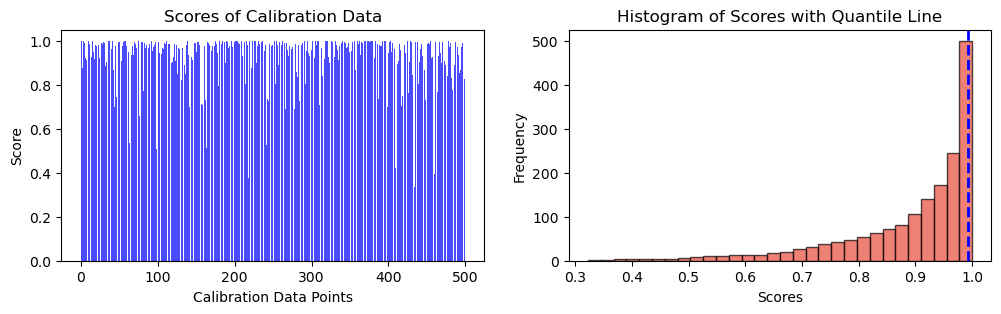

(None,)

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
# Plot scores of calibration data
ax[0].bar(np.arange(len(cal_scores)), height = cal_scores, alpha = 0.7, color = 'b')
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Calibration Data Points")
ax[0].set_title("Scores of Calibration Data")

# Plot the histogram
n, bins, _ = ax[1].hist(cal_scores, bins=30, alpha=0.7, cumulative = True, color='#E94B3CFF', edgecolor='black', label='Score Frequency')
ax[1].axvline(qhat, color='b', linestyle='dashed', linewidth=2, label=r"Quantile (${q_{val}}$ = " + str(("{:.2f}")).format(qhat) + ")")
ax[1].set_xlabel('Scores')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Scores with Quantile Line')
plt.show(),

In [76]:
def class_label(i):
    labels = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 
                5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    return labels[i]

In [77]:
def get_pred_str(pred):
    pred_str = "{"
    for i in pred:
        pred_str += class_label(i) + ', '  # Use comma instead of space
    pred_str = pred_str.rstrip(', ') + "}"  # Remove the trailing comma and add closing curly brace
    return pred_str


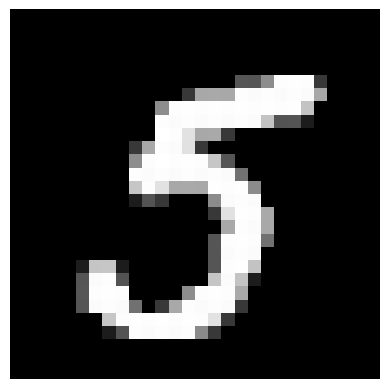

The prediction set is: {1, 2, 3, 4, 5, 6, 8, 9}


In [78]:
index = 300
img_pi = val_smx[index].argsort()[::-1]
img_srt = np.take_along_axis(val_smx[index], img_pi, axis=0).cumsum()
prediction_set = np.take_along_axis(img_srt <= qhat, img_pi.argsort(), axis=0)
plt.figure()
plt.imshow(X_calib[index].reshape(28, 28), cmap="gray")
plt.axis("off")
plt.show()
print(f"The prediction set is: {get_pred_str(prediction_set.nonzero()[0].tolist())}")